In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sn
import matplotlib.pyplot as pyplot
import pymc3 as pm

from pymc3 import traceplot


# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy
import theano

from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag


import arviz as az #pymc3 plot functions use Arviz. Either command works. Ex: az.plot_posterior = pm.plot_posterior

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Import Data
NYCData = "nyc.csv" 
NYCDf = pd.read_csv(NYCData)

NYCDf.drop(["Unnamed: 0", "X", "Case"], axis = 1, inplace = True)
NYCDf.set_index("Restaurant", inplace = True)
NYCDf["Intercept"] = 1

NYCDf

,Price,Food,Decor,Service,East,Intercept
Restaurant,,,,,,
Daniella Ristorante,43,22,18,20,0,1
Tello's Ristorante,32,20,19,19,0,1
Biricchino,34,21,13,18,0,1
Bottino,41,20,20,17,0,1
Da Umberto,54,24,19,21,0,1
...,...,...,...,...,...,...
Baci,31,17,15,16,0,1
Puccini,26,20,16,17,0,1
Bella Luna,31,18,16,17,0,1


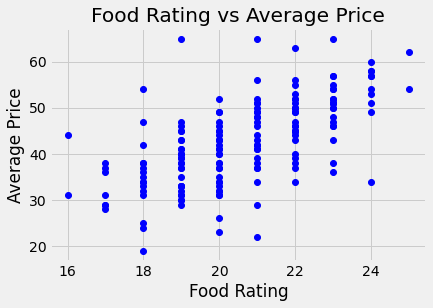

In [3]:
pyplot.style.use('fivethirtyeight')
pyplot.plot(NYCDf["Food"],NYCDf["Price"], "bo")
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.title("Food Rating vs Average Price")
pyplot.show()

In [4]:
x = NYCDf["Food"]
y = NYCDf["Price"]

A = np.vstack([x, np.ones(len(x))]).T

In [5]:
model, SSE = np.linalg.lstsq(A, y, rcond=None)[:2]

print(f"""The values gathered from our data are {model[1]} for our intercept and {model[0]} for our slope.""")

The values gathered from our data are -17.83214855650661 for our intercept and 2.9389598143043676 for our slope.


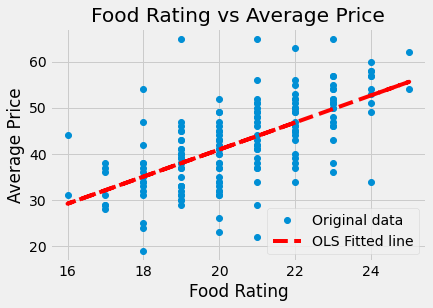

In [6]:
pyplot.style.use('fivethirtyeight')
_ =pyplot.plot(x, y, 'o', label='Original data')
_ = pyplot.plot(x, model[0]*x + model[1], 'r--', label='OLS Fitted line')
_ = pyplot.xlabel("Food Rating")
_ = pyplot.ylabel("Average Price")
_ = pyplot.title("Food Rating vs Average Price")
_ = pyplot.legend()
pyplot.show()

# Informed Prior

In [7]:
with pm.Model() as linear_model_informed:
    # Intercept
    intercept = pm.Normal("Intercept", mu = 0, sd = 5)
    
    # Slope 
    slope = slope1 = pm.Normal("slope", mu = 0, sd = 5)
    
    # Standard deviation
    sigma = pm.HalfNormal("sigma", sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * NYCDf["Food"]
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = NYCDf["Price"].values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_informed = pm.sample(100, step)

C:\Users\Test\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 41 seconds.
The acceptance probability does not match the target. It is 0.6698880928660499, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\Test\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
C:\Users\Test\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

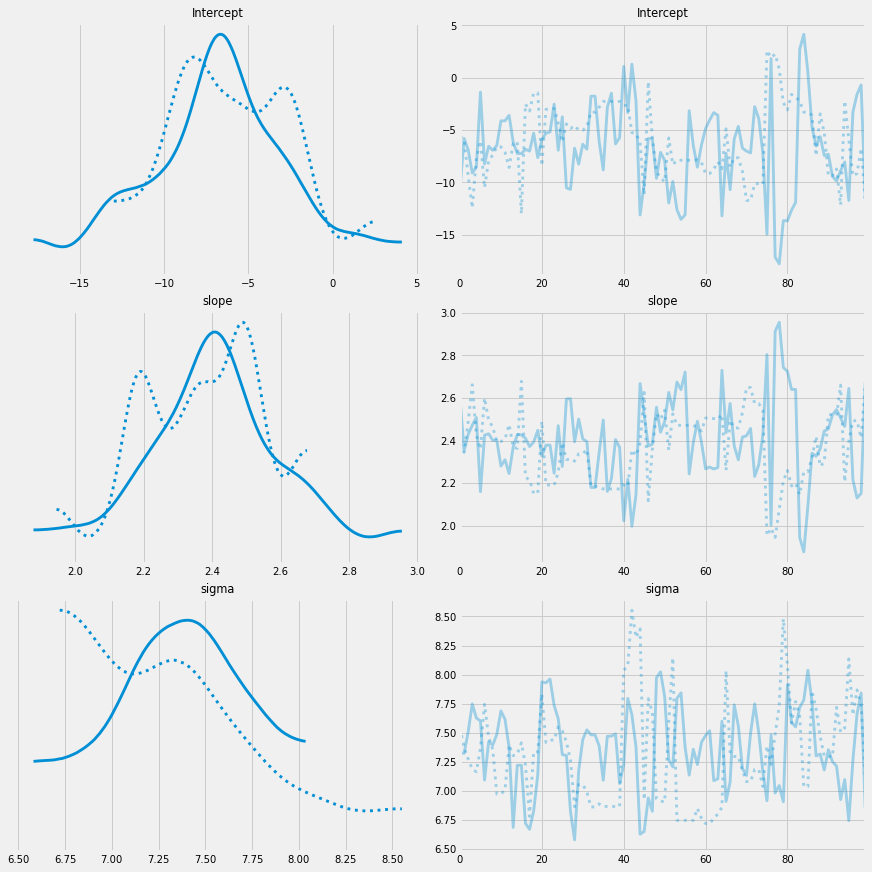

In [8]:
pm.traceplot(linear_trace_informed, figsize = (12, 12))

C:\Users\Test\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

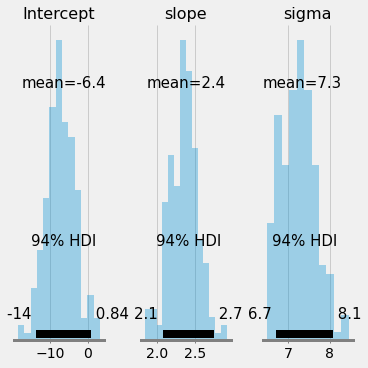

In [9]:
pm.plot_posterior(linear_trace_informed, figsize = (5, 5), kind = "hist")

C:\Users\Test\anaconda3\lib\site-packages\pymc3\plots\posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


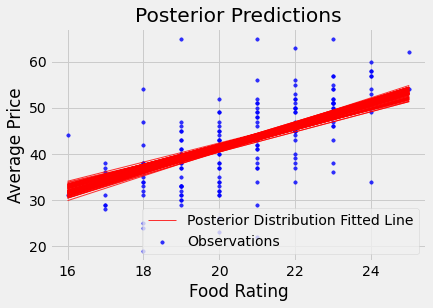

In [10]:
pm.plot_posterior_predictive_glm(linear_trace_informed, samples = 100, eval=np.linspace(16,25, 100), linewidth = 1, 
                                 color = "red", alpha = 0.8, label = "Posterior Distribution Fitted Line",
                                lm = lambda x, sample: sample["Intercept"] + sample["slope"] * x);
pyplot.scatter(NYCDf["Food"], y.values, s = 12, alpha = 0.8, c = "blue", label = "Observations")
pyplot.title("Posterior Predictions")
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.legend()

In [11]:
bayes_prediction = linear_trace_informed["Intercept"] + linear_trace_informed["slope"] * 20

Text(0.5, 1.0, 'Posterior Prediction for Food Rating of 20')

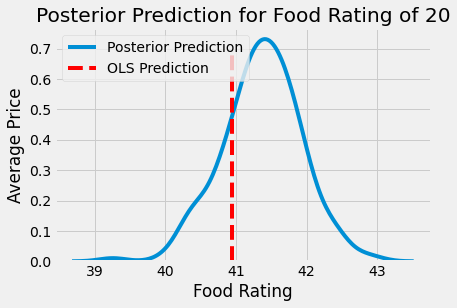

In [12]:
sn.kdeplot(bayes_prediction, label = 'Posterior Prediction')
pyplot.vlines(x = model[1] + model[0] * 20, ymin = 0, ymax = 0.7, label = 'OLS Prediction', colors = 'red', linestyles='--')
pyplot.legend()
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.title("Posterior Prediction for Food Rating of 20")

# Uninformed

In [13]:
with pm.Model() as linear_model_uninformed:
    # Intercept
    intercept = pm.Normal("Intercept", mu = 0, sd = 100)
    
    # Slope 
    slope = slope1 = pm.Normal("slope", mu = 0, sd = 100)
    
    # Standard deviation
    sigma = pm.HalfNormal("sigma", sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * NYCDf["Food"]
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = NYCDf["Price"].values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_uninformed = pm.sample(100, step)

C:\Users\Test\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 41 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\Test\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
C:\Users\Test\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

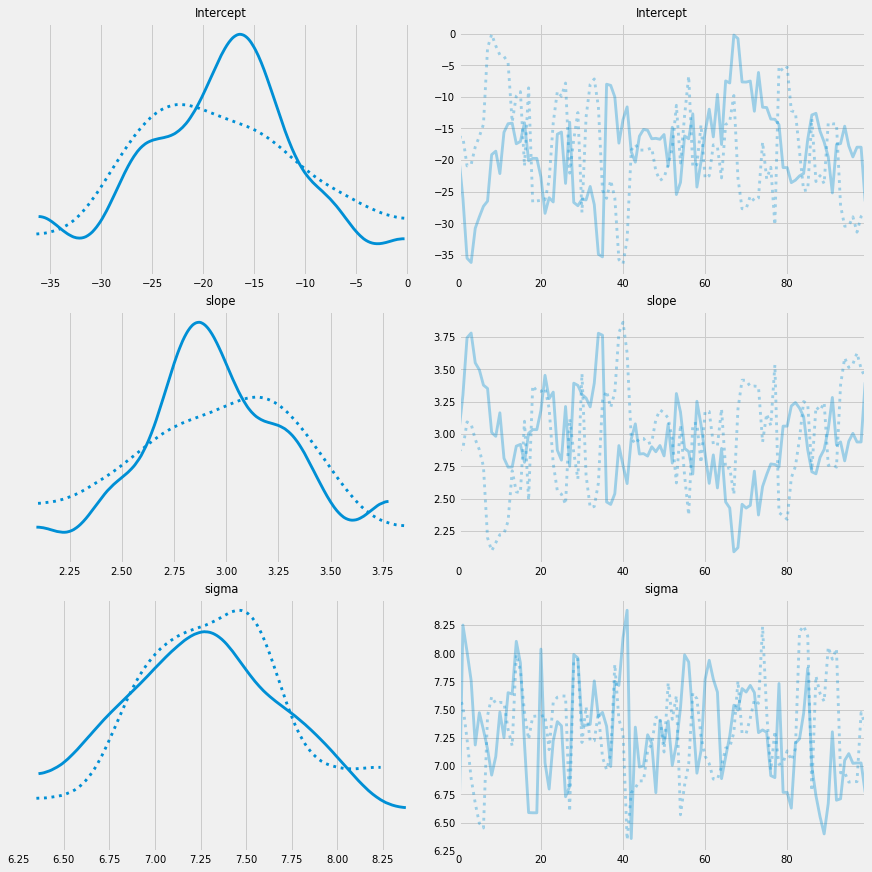

In [14]:
pm.traceplot(linear_trace_uninformed, figsize = (12, 12))

C:\Users\Test\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

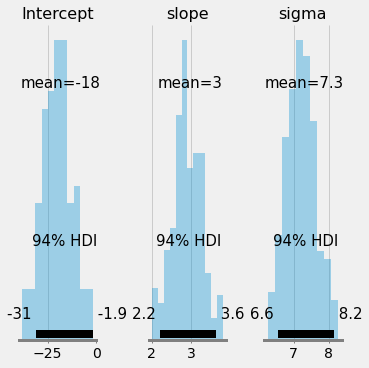

In [15]:
pm.plot_posterior(linear_trace_uninformed, figsize = (5, 5), kind = "hist")

C:\Users\Test\anaconda3\lib\site-packages\pymc3\plots\posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


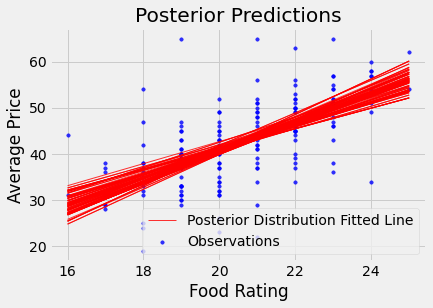

In [16]:
pm.plot_posterior_predictive_glm(linear_trace_uninformed, samples = 100, eval=np.linspace(16,25, 100), linewidth = 1, 
                                 color = "red", alpha = 0.8, label = "Posterior Distribution Fitted Line",
                                lm = lambda x, sample: sample["Intercept"] + sample["slope"] * x);
pyplot.scatter(NYCDf["Food"], y.values, s = 12, alpha = 0.8, c = "blue", label = "Observations")
pyplot.title("Posterior Predictions")
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.legend()

In [17]:
bayes_prediction = linear_trace_uninformed["Intercept"] + linear_trace_uninformed["slope"] * 20

Text(0.5, 1.0, 'Posterior Prediction for Food Rating of 20')

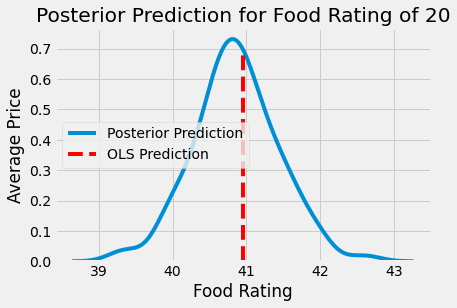

In [18]:
sn.kdeplot(bayes_prediction, label = 'Posterior Prediction')
pyplot.vlines(x = model[1] + model[0] * 20, ymin = 0, ymax = 0.7, label = 'OLS Prediction', colors = 'red', linestyles='--')
pyplot.legend()
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.title("Posterior Prediction for Food Rating of 20")